<a href="https://colab.research.google.com/github/rjsdn2308/medical.data/blob/main/11_tf_binding_prediction_RNA_inferience_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepChem 설치
Colab 노트북에 DeepChem 설치

tensorflow 기반 모델을 사용할 것이므로 pip install 명령에 [tensorflow]를 추가하여 필요한 종속성도 설치

In [22]:
# DeepChem 설치시 Keras 종속성 버전 일치를 위해 아래 환경 변수 설정 후 import 진행
import os
os.environ["TF_USE_LEGACY_KERAS"] = '1'

In [23]:
!pip install deepchem[tensorflow]

In [24]:
!pip install tf_keras

In [25]:
import deepchem as dc
dc.__version__

'2.8.0'

### warning 메시지 생략

In [26]:
import warnings
warnings.filterwarnings(action='ignore')

# 전사인자 결합 예측 모델

- JUND 전사 인자의 결합 예측을 위한 CNN 모델 생성
- 2차원 이미지가 아닌 1차원 데이터 사용하는 CNN 모델

### 라이브러리 불러오기

In [27]:
import deepchem as dc # DeepChem 라이브러리를 dc라는 이름(alias)으로 임포트합니다.
import tensorflow as tf
import tensorflow.keras.layers as layers

### 데이터 불러오기 및 확인

In [28]:
train = dc.data.DiskDataset('/content/drive/MyDrive/2025-1/md/data (1)/train_dataset')
valid = dc.data.DiskDataset('/content/drive/MyDrive/2025-1/md/data (1)/valid_dataset')

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
train.X.shape

(276216, 101, 4)

In [31]:
train.y.shape

(276216, 1)

In [32]:
train

<DiskDataset X.shape: (np.int64(276216), np.int64(101), np.int64(4)), y.shape: (np.int64(276216), np.int64(1)), w.shape: (np.int64(276216), np.int64(1)), task_names: [0]>

### 모델 생성

In [33]:
features = tf.keras.Input(shape=(101, 4)) # 입력 레이어 정의: 입력 데이터는 (101, 4) 형태의 시퀀스 데이터를 의미
prev = features

for i in range(3):
    # 1D 합성곱 레이어: 필터 수 15, 커널 크기 10, ReLU 활성화 함수 사용
    # padding='same'으로 출력 길이가 입력과 동일하도록 유지
    prev = layers.Conv1D(filters=15, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.5)(prev)

# 마지막 Conv 블록 출력값을 평탄화 (Flatten)한 후, Dense 레이어를 통해 출력 뉴런 1개 생성
logits = layers.Dense(units=1)(layers.Flatten()(prev))

# 출력값에 시그모이드 활성화 함수를 적용하여 최종 출력 생성 (0~1 사이 확률값)
output = layers.Activation(tf.math.sigmoid)(logits)

In [34]:
keras_model = tf.keras.Model(inputs=features, outputs=[output, logits])

# DeepChem의 KerasModel 클래스를 사용하여 사용자 정의 Keras 모델을 래핑
model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.SigmoidCrossEntropy(), # 손실 함수로 Sigmoid Cross Entropy를 사용
    output_types=['prediction', 'loss'],
    batch_size=1000,
    model_dir='tf')

### 모델 학습 및 평가

In [35]:
# ROC AUC 점수를 사용하기 위한 Metric 객체 생성
# roc_auc_score는 분류기의 성능을 평가할 때 흔히 사용되는 지표로,
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
for i in range(20):
    model.fit(train, nb_epoch=10)
    print(model.evaluate(train, [metric]))
    print(model.evaluate(valid, [metric])) # 검증 데이터셋(valid)에 대한 성능 평가 (과적합 여부 확인 목적)

{'roc_auc_score': np.float64(0.6328854029040212)}
{'roc_auc_score': np.float64(0.5899053037019093)}
{'roc_auc_score': np.float64(0.7665241744666336)}
{'roc_auc_score': np.float64(0.7274534497191625)}
{'roc_auc_score': np.float64(0.8005195716710269)}
{'roc_auc_score': np.float64(0.7393842190633326)}
{'roc_auc_score': np.float64(0.8203176882289139)}
{'roc_auc_score': np.float64(0.7339808782566668)}
{'roc_auc_score': np.float64(0.8310328501690165)}
{'roc_auc_score': np.float64(0.7284959078624582)}
{'roc_auc_score': np.float64(0.8407217194194347)}
{'roc_auc_score': np.float64(0.7212880501455686)}
{'roc_auc_score': np.float64(0.8513610501061234)}
{'roc_auc_score': np.float64(0.7225531344367091)}
{'roc_auc_score': np.float64(0.8636088578237702)}
{'roc_auc_score': np.float64(0.7274782025593143)}
{'roc_auc_score': np.float64(0.8696090690758136)}
{'roc_auc_score': np.float64(0.7315598811544923)}
{'roc_auc_score': np.float64(0.857362583512198)}
{'roc_auc_score': np.float64(0.7400583230702845)}
{

# 모델 수정
- Dense층 학습 시 전사 인자 조절에 관여하는 RNA 간섭 feature 추가
- feature 레이어가 2개라 fit함수 사용 불가능
- 배치별 반복 학습 수행
- iterbatches() 함수를 통해 모델에 필요한 입력 데이터 배치별 처리

In [36]:
import numpy as np

In [37]:
span_accessibility = {}
for line in open('/content/drive/MyDrive/2025-1/md/data (1)/accessibility.txt'):
    fields = line.split()
    span_accessibility[fields[0]] = float(fields[1])

In [38]:
span_accessibility

{'chr22:20208963-20209064': 0.003902,
 'chr22:29673572-29673673': 0.004378,
 'chr22:28193720-28193821': 0.001946,
 'chr22:43864274-43864375': 0.003869,
 'chr22:18261550-18261651': 0.003066,
 'chr22:49798024-49798125': 0.003794,
 'chr22:43088594-43088695': 0.005292,
 'chr22:35147671-35147772': 0.002015,
 'chr22:49486843-49486944': 0.001046,
 'chr22:21014236-21014337': 0.003394,
 'chr22:46113241-46113342': 0.004074,
 'chr22:18183679-18183780': 0.005725,
 'chr22:50791864-50791965': 0.005023,
 'chr22:18811798-18811899': 0.005777,
 'chr22:36467842-36467943': 0.003452,
 'chr22:33428651-33428752': 0.006423,
 'chr22:50113043-50113144': 0.002428,
 'chr22:33643781-33643882': 0.004774,
 'chr22:33543993-33544094': 0.005169,
 'chr22:50467250-50467351': 0.006465,
 'chr22:37420272-37420373': 0.002894,
 'chr22:50296661-50296762': 0.003144,
 'chr22:19833041-19833142': 0.002302,
 'chr22:33546316-33546417': 0.003757,
 'chr22:24708412-24708513': 0.003336,
 'chr22:46228987-46229088': 0.005614,
 'chr22:3004

In [39]:
features = tf.keras.Input(shape=(101, 4))
accessibility = tf.keras.Input(shape=(1,))

prev = features
for i in range(3):
    prev = layers.Conv1D(filters=15, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.5)(prev)

prev = layers.Concatenate()([layers.Flatten()(prev), accessibility])

logits = layers.Dense(units=1)(prev)
output = layers.Activation(tf.math.sigmoid)(logits)
keras_model = tf.keras.Model(inputs=[features, accessibility], outputs=[output, logits])

model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.SigmoidCrossEntropy(),
    output_types=['prediction', 'loss'],
    batch_size=1000,
    model_dir='chromatin')

In [40]:
def generate_batches(dataset, epochs):
    for epoch in range(epochs):
        for X, y, w, ids in dataset.iterbatches(batch_size=1000, pad_batches=True):
            yield ([X, np.array([span_accessibility[id] for id in ids])], [y], [w])

### 성능 평가

In [41]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
for i in range(20):
    model.fit_generator(generate_batches(train, epochs=10))
    print(model.evaluate_generator(generate_batches(train, 1), [metric]))
    print(model.evaluate_generator(generate_batches(valid, 1), [metric]))

{'roc_auc_score': np.float64(0.6608679984121266)}
{'roc_auc_score': np.float64(0.6135083190020048)}
{'roc_auc_score': np.float64(0.7190567122603635)}
{'roc_auc_score': np.float64(0.6949276438437748)}
{'roc_auc_score': np.float64(0.7835863762938688)}
{'roc_auc_score': np.float64(0.7497134493362827)}
{'roc_auc_score': np.float64(0.8303870983720189)}
{'roc_auc_score': np.float64(0.768158541446301)}
{'roc_auc_score': np.float64(0.8478552571904996)}
{'roc_auc_score': np.float64(0.7917775654324383)}
{'roc_auc_score': np.float64(0.8526516255104855)}
{'roc_auc_score': np.float64(0.791706668507139)}
{'roc_auc_score': np.float64(0.8577343503858017)}
{'roc_auc_score': np.float64(0.7878886178861788)}
{'roc_auc_score': np.float64(0.8680499114541005)}
{'roc_auc_score': np.float64(0.7816531324725011)}
{'roc_auc_score': np.float64(0.875167018044436)}
{'roc_auc_score': np.float64(0.7955633668101387)}
{'roc_auc_score': np.float64(0.8706956440529414)}
{'roc_auc_score': np.float64(0.7803792922046868)}
{'r

# RNA 간섭 예측 모델
- RNA 서열을 입력 데이터로 사용해 RNA 간섭의 효과 예측하는 CNN 모델

In [42]:
import matplotlib.pyplot as plt

### 데이터 불러오기 및 확인

In [43]:
train = dc.data.DiskDataset('/content/drive/MyDrive/2025-1/md/data (1)/train_siRNA')
valid = dc.data.DiskDataset('/content/drive/MyDrive/2025-1/md/data (1)/valid_siRNA')

In [44]:
train.X.shape

(2187, 21, 4)

In [45]:
train.y.shape

(2187, 1)

In [46]:
train.X

array([[[0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]],

       [[0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1]],

       ...,

       [[1, 0, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        ...,
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]],

       [[0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        ...,
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]],

       [[0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ...,
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]]], dtype=int8)

### 모델 생성

In [47]:
features = tf.keras.Input(shape=(21, 4)) # 입력층 정의: 21개의 시퀀스 길이, 각 위치당 4개의 피처
prev = features
for i in range(2): # Conv1D + Dropout 블록 2회 반복
    prev = layers.Conv1D(filters=10, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.3)(prev)
output = layers.Dense(units=1, activation=tf.math.sigmoid)(layers.Flatten()(prev)) # Flatten 후 Dense 레이어로 이진 출력 생성 (시그모이드 활성화)
keras_model = tf.keras.Model(inputs=features, outputs=output)
model = dc.models.KerasModel( # DeepChem KerasModel로 래핑
    keras_model,
    loss=dc.models.losses.L2Loss(),  # 회귀 또는 연속값 예측에 적합
    batch_size=1000,
    model_dir='rnai') # 모델 저장 디렉터리

### 모델 학습 및 평가

In [48]:
train_scores = []
valid_scores = []

In [49]:
metric = dc.metrics.Metric(dc.metrics.pearsonr, mode='regression')

for i in range(20):
    model.fit(train, nb_epoch=10)
    train_score = model.evaluate(train, [metric])['pearsonr']
    valid_score = model.evaluate(valid, [metric])['pearsonr']

    train_scores.append(train_score)
    valid_scores.append(valid_score)

    print(train_score)
    print(valid_score)

0.12114565105948849
0.18993968344779505
0.3904532431358325
0.38872181416357093
0.5146852441598426
0.4712289488809315
0.5673585759053137
0.5145528892341845
0.6105794325641194
0.5551660396423661
0.6471002117284237
0.5739753810973387
0.6701358805733816
0.5933852449122338
0.6822346713782073
0.6029263556654971
0.691690608420358
0.6111498629291432
0.6989844098839655
0.6130127266683529
0.7050020837671718
0.6151805480501191
0.7110671194266116
0.6191275350453438
0.715424433284757
0.620998634280477
0.7198896223151876
0.6242358970161235
0.7238530179938587
0.6225324812259898
0.7272819800641157
0.6237225964292705
0.7314683422744969
0.6274077215398464
0.734450497375073
0.6283688507459324
0.7375129012667813
0.6295398940813167
0.7407658807065778
0.6313920172411343


### 모델 성능 시각화

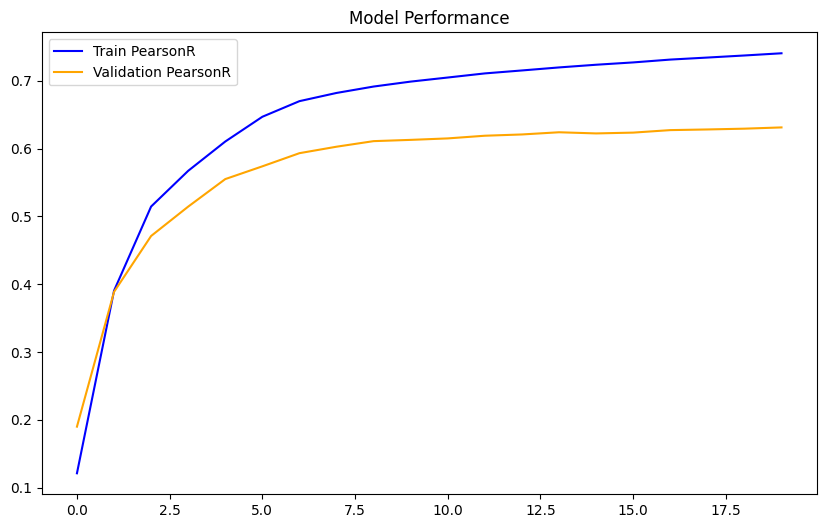

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(train_scores, label='Train PearsonR', color='blue')
plt.plot(valid_scores, label='Validation PearsonR', color='orange')

plt.title('Model Performance')
plt.legend()
plt.show()